# Predicting Power Consumption in Tetouan City
## Application of feature engineering and different models to improve prediction outcomes for power consumption in Tetouan City
### This analysis will use the available features to generate additional features that will help predict the power consumption of Tetouan City. Also, these features will be tested on different machine learning models to determine the model that will minimize the cost function.

__Title__: Power consumption of Tetouan city Data Set   
__Authors__: Abdulwahed Salam and Abdelaaziz El Hibaoui of Abdelmalek Essaadi University   
__Source__: https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city#

In [1]:
# Import Numpy and Pandas libraries
import numpy as np
import pandas as pd

# Set the maximum number of rows and columns to display without compressing the display results.
pd.options.display.max_rows=100
pd.options.display.max_columns=100

# Open the 'Tetuan City power consumption.csv' and convert into a Pandas DataFrame.
power = pd.read_csv('Tetuan City power consumption.csv')

# Display the initial rows.
power.head()

DateTime  Temperature  Humidity  Wind Speed  general diffuse flows  \
0  1/1/2017 0:00        6.559      73.8       0.083                  0.051   
1  1/1/2017 0:10        6.414      74.5       0.083                  0.070   
2  1/1/2017 0:20        6.313      74.5       0.080                  0.062   
3  1/1/2017 0:30        6.121      75.0       0.083                  0.091   
4  1/1/2017 0:40        5.921      75.7       0.081                  0.048   

   diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
0          0.119               34055.69620                16128.87538   
1          0.085               29814.68354                19375.07599   
2          0.100               29128.10127                19006.68693   
3          0.096               28228.86076                18361.09422   
4          0.085               27335.69620                17872.34043   

   Zone 3  Power Consumption  
0                20240.96386  
1                20131.08434  
2                19668.43373  
3                18899.27711  
4                18442.40964

In [2]:
# View the statistical figures of the numerical columns.
power.describe()

Temperature      Humidity    Wind Speed  general diffuse flows  \
count  52416.000000  52416.000000  52416.000000           52416.000000   
mean      18.810024     68.259518      1.959489             182.696614   
std        5.815476     15.551177      2.348862             264.400960   
min        3.247000     11.340000      0.050000               0.004000   
25%       14.410000     58.310000      0.078000               0.062000   
50%       18.780000     69.860000      0.086000               5.035500   
75%       22.890000     81.400000      4.915000             319.600000   
max       40.010000     94.800000      6.483000            1163.000000   

       diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
count   52416.000000              52416.000000               52416.000000   
mean       75.028022              32344.970564               21042.509082   
std       124.210949               7130.562564                5201.465892   
min         0.011000              13895.696200                8560.081466   
25%         0.122000              26310.668692               16980.766032   
50%         4.456000              32265.920340               20823.168405   
75%       101.000000              37309.018185               24713.717520   
max       936.000000              52204.395120               37408.860760   

       Zone 3  Power Consumption  
count               52416.000000  
mean                17835.406218  
std                  6622.165099  
min                  5935.174070  
25%                 13129.326630  
50%                 16415.117470  
75%                 21624.100420  
max                 47598.326360

In [3]:
# Determine column dtypes and presence of null values.
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   Wind Speed                 52416 non-null  float64
 4   general diffuse flows      52416 non-null  float64
 5   diffuse flows              52416 non-null  float64
 6   Zone 1 Power Consumption   52416 non-null  float64
 7   Zone 2  Power Consumption  52416 non-null  float64
 8   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


## Initial feedback with the Dataset
It appears that the dataset does not contain any null value. All the numerical values are in float dtype while the DateTime column needs to be converted to DateTime format.

## Determine correlations between different columns
We'll select columns to determine correlations with a scatter_matrix and heatmap.

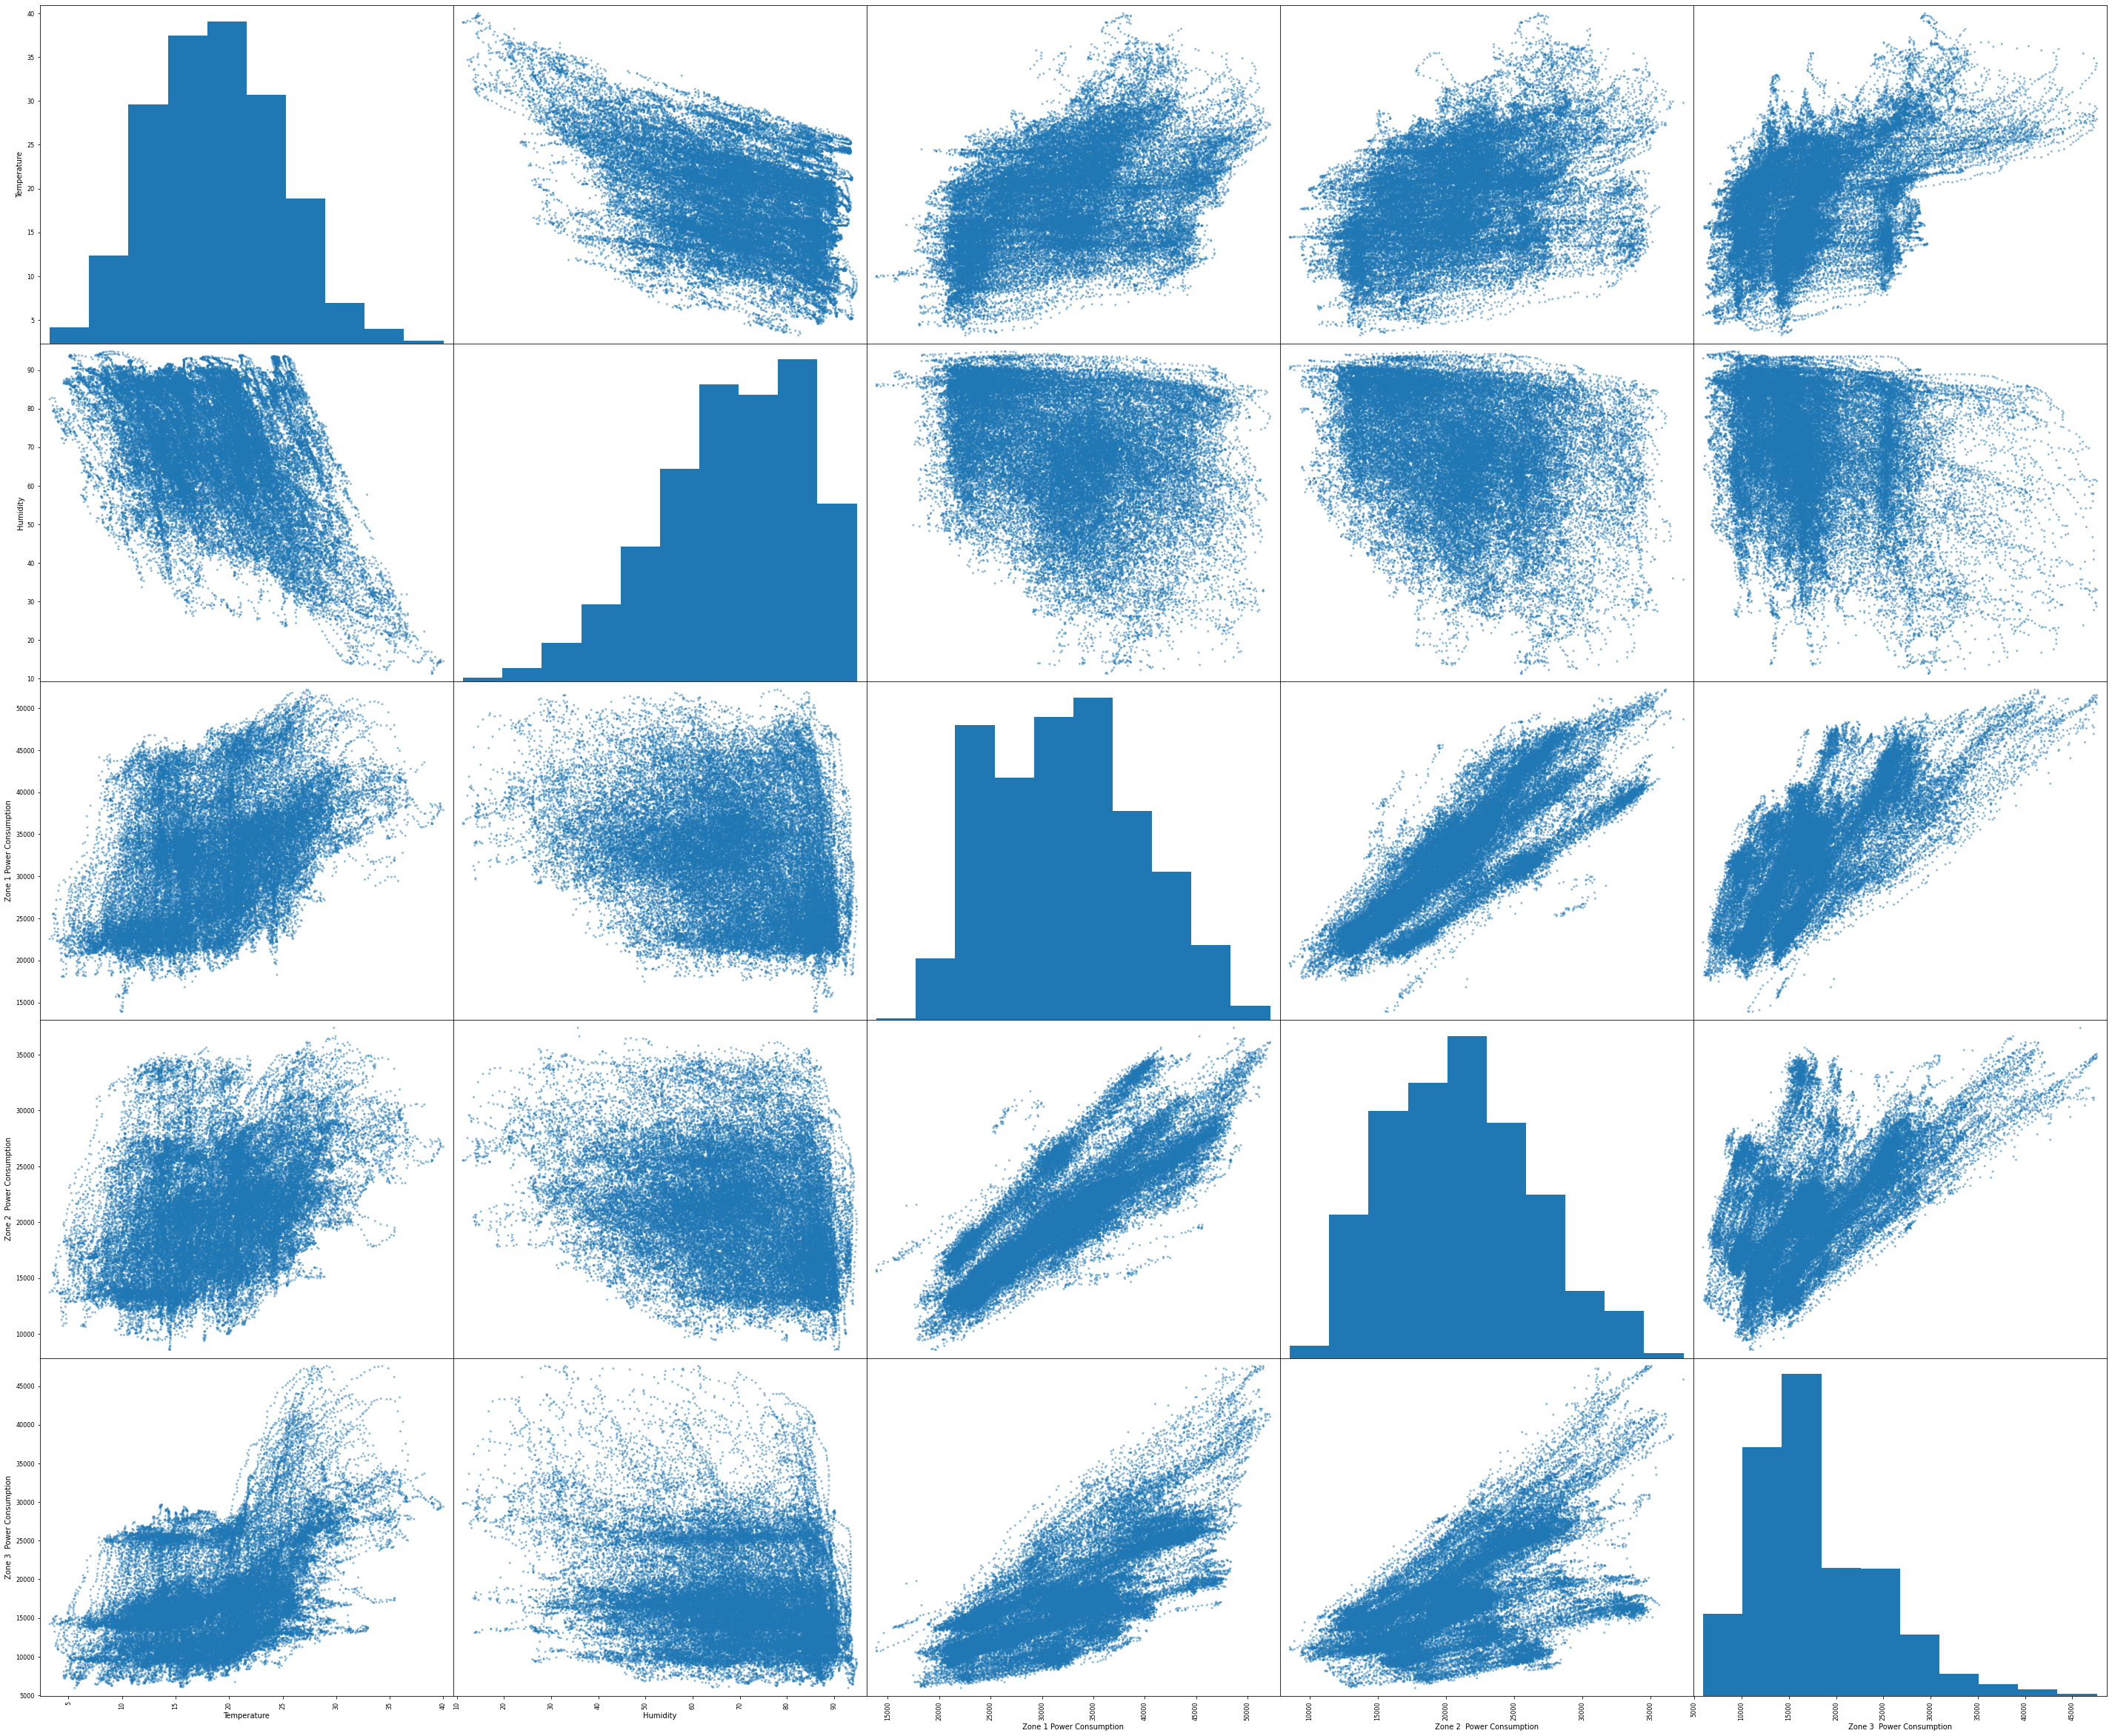

In [4]:
# Import 'matplotlib.pyplot' with '%matplotlib inline'
import matplotlib.pyplot as plt
%matplotlib inline

# Import 'scatter_matrix' from pandas
from pandas.plotting import scatter_matrix
scatter_matrix(power[['Temperature', 'Humidity', 'Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption']], figsize=(50,42))
plt.show()

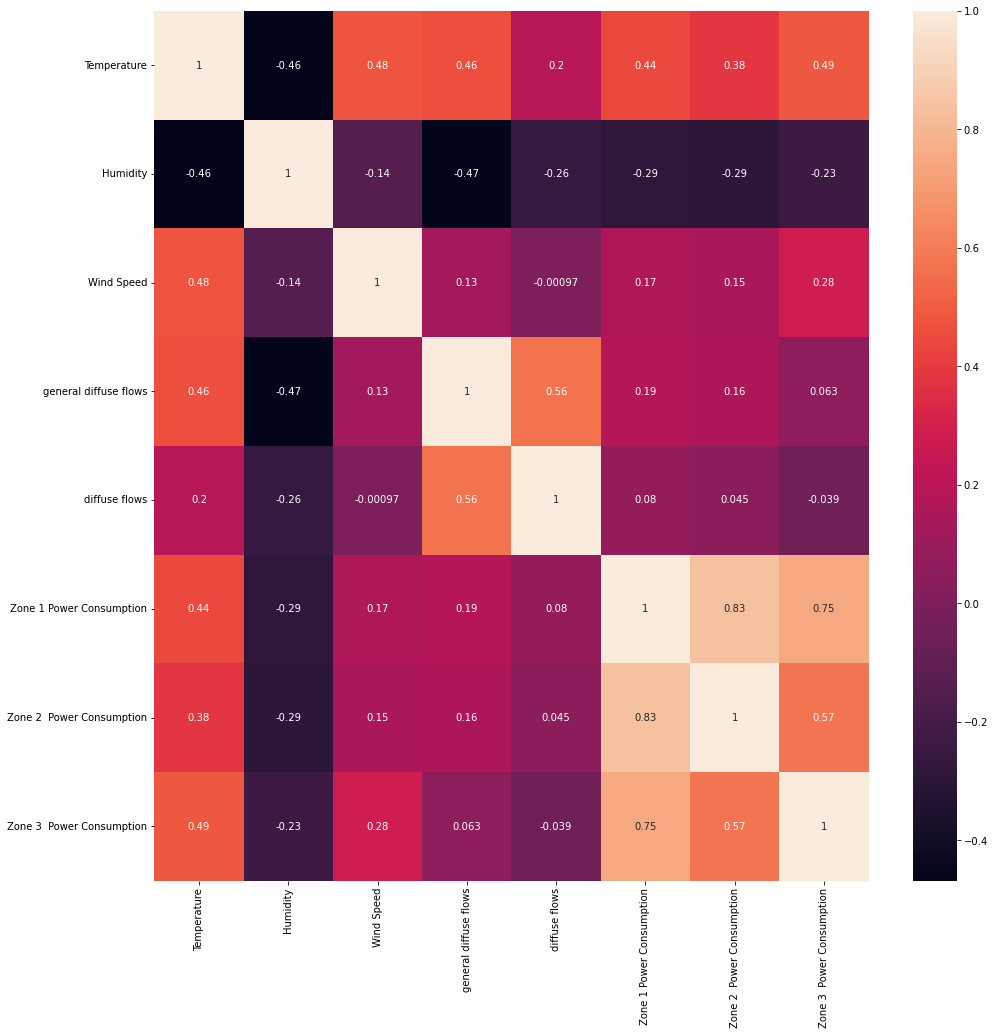

In [5]:
# Set the parameters of the plot.
fig, ax = plt.subplots(figsize=(16,16))

# Import Seaborn to use its heatmap attribute.
import seaborn as sns
ax = sns.heatmap(power.corr(), annot=True)

## Correlation Findings
Based from the results, we can see that temperature, humidity, and wind speed generate correlations with our target values: the power consumption columns from Zone 1 to Zone 3.

There is also collinearity with Zone 1, Zone2, and Zone 3 Power Consumption columns. We need to ensure that their values don't "interact" with each other.

For now, we can convert the DateTime column to DateTime format.

In [6]:
power['DateTime'] = pd.to_datetime(power['DateTime'])
power['Date'] = power['DateTime'].dt.date
power['Time'] = power['DateTime'].dt.time

## Features Engineering

To generate better prediction outcomes, we can generate features from the existing columns of features. To start, we need to create functions that will generate the average and standard deviation values for different columns.

In [7]:
# Create a function that will take the average of observed values which will also take the number of observations needed.
def avg_column(df, target_column, num_values):
    output_col = []
    for index, row in df.iterrows():
        start = index - num_values
        end = index
        target = df.columns.get_loc(target_column)
        average = np.mean(df.iloc[start:end,target])
        output_col.append(average)
    return output_col

# Just like 'avg_column', a function will be created to take the standard deviation of recorded observations.
def std_column(df, target_column, num_values):
    output_col = []
    for index, row in df.iterrows():
        start = index - num_values
        end = index
        target = df.columns.get_loc(target_column)
        std = np.std(df.iloc[start:end,target])
        output_col.append(std)
    return output_col

We have temperature and humidity columns for analysis. We can generate an additional column that will compute for the Heat Index of Tetouan City at the time of the recorded observation. We can also generate labels to determine if the Heat Index is dangerous for humans.

Source for Heat Index formula and labels: https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml

In [8]:
# Create function for Heat Index
def heat_index(dataframe, temperature, humidity, fahrenheit=False):
    df = dataframe.copy()
    if fahrenheit == False:
        df[temperature] = (df[temperature]*1.8)+32
    temp_iloc = df.columns.get_loc(temperature)
    hum_iloc = df.columns.get_loc(humidity)
    hi_values = []
    for i in range(df.shape[0]):
        t = df.iloc[i,temp_iloc]
        rh = df.iloc[i,hum_iloc]/100
        hi = -42.379+(2.04901523*t)+(10.14333127*rh)-(0.22475541*t*rh)-(0.00683783*t*t)-(0.05481717*rh*rh)+(0.00122874*t*t*rh)+(0.00085282*t*rh*rh)-(0.00000199*t*t*rh*rh)
        if (rh < 0.13) and (t >= 80) and (t <= 112):
            hi -= ((13-rh)/4)*np.sqrt((17-np.abs(t-95))/17)
        elif (rh > 0.85) and (t >= 80) and (t <= 87):
            hi += ((rh-85)/10) * ((87-t)/5)
        if hi < 80:
            hi = 0.5*(t+61+((t-68)*1.2)+(rh*0.094))
            hi = (hi + t) / 2
        hi_values.append(hi)
    hi_output = []
    if fahrenheit == False:
        for f in hi_values:
            c = (f-32) * (5/9)
            hi_output.append(c)
    else:
        hi_output = hi_values
    return hi_output

In [9]:
# Create function to generate labels for the Heat Index
def heat_index_label(hi):
    if hi < 26.667:
        return 'Safe'
    elif (hi >= 26.667) and (hi <= 32.222):
        return 'Caution'
    elif (hi > 32.222) and (hi <= 39.444):
        return 'Extreme Caution'
    elif (hi > 39.444) and (hi <= 51.111):
        return 'Danger'
    elif (hi > 51.111):
        return 'Extreme Danger'

After generating these functions, we can apply these functions to the dataset.

We can also generate dummies for the labels created from the function.

In [10]:
# Create 'Heat Index' column that will generate the Heat Index for each row observation.
power['Heat Index'] = heat_index(power, 'Temperature', 'Humidity', fahrenheit=False)

# Apply the 'heat_index_label' function to the 'Heat Index' column to generate the column 'Heat Index Label'.
power['Heat Index Label'] = power['Heat Index'].apply(heat_index_label)

# Assign dummies for the 'Heat Index Label' column.
hi_dummies = pd.get_dummies(power['Heat Index Label'], prefix='Heat Index Label')
power = pd.concat([power, hi_dummies], axis=1)

# Drop the 'Heat Index Label' since we already generated the dummy columns from the labels.
power = power.drop(columns='Heat Index Label')

## Generation of averages and standard deviations for selected columns
We can now generate averages and standard deviations with observations from 1 hour, 3 hours, and 6 hours. We will apply these results to new columns.

NOTE: The results from these functions will not include the observations from the row the results will be included to. Including the row for computation where the result will be included will create data 'leakage' and will disregard the 'predictive' values from these data since actual data is already included in the computation.

In [11]:
# Apply the functions to the temperature, humidity, and wind speed columns.
power['Temp Avg 1 Hour'] = avg_column(power, 'Temperature', 7)
power['Temp Avg 3 Hours'] = avg_column(power, 'Temperature', 21)
power['Temp Avg 6 Hours'] = avg_column(power, 'Temperature', 42)

power['Temp Std 1 Hour'] = std_column(power, 'Temperature', 7)
power['Temp Std 3 Hours'] = std_column(power, 'Temperature', 21)
power['Temp Std 6 Hours'] = std_column(power, 'Temperature', 42)

power['Hum Avg 1 Hour'] = avg_column(power, 'Humidity', 7)
power['Hum Avg 3 Hours'] = avg_column(power, 'Humidity', 21)
power['Hum Avg 6 Hours'] = avg_column(power, 'Humidity', 42)

power['Hum Std 1 Hour'] = std_column(power, 'Humidity', 7)
power['Hum Std 3 Hours'] = std_column(power, 'Humidity', 21)
power['Hum Std 6 Hours'] = std_column(power, 'Humidity', 42)

power['Wind Avg 1 Hour'] = avg_column(power, 'Wind Speed', 7)
power['Wind Avg 3 Hours'] = avg_column(power, 'Wind Speed', 21)
power['Wind Avg 6 Hours'] = avg_column(power, 'Wind Speed', 42)

power['Wind Std 1 Hour'] = std_column(power, 'Wind Speed', 7)
power['Wind Std 3 Hours'] = std_column(power, 'Wind Speed', 21)
power['Wind Std 6 Hours'] = std_column(power, 'Wind Speed', 42)

In [12]:
# Compute the averages and standard deviations for the power consumption columns.
power['Zone 1 Consumption Avg 1 Hour'] = avg_column(power, 'Zone 1 Power Consumption', 7)
power['Zone 1 Consumption Avg 3 Hours'] = avg_column(power, 'Zone 1 Power Consumption', 21)
power['Zone 1 Consumption Avg 6 Hours'] = avg_column(power, 'Zone 1 Power Consumption', 42)

power['Zone 1 Consumption Std 1 Hours'] = std_column(power, 'Zone 1 Power Consumption', 7)
power['Zone 1 Consumption Std 2 Hours'] = std_column(power, 'Zone 1 Power Consumption', 21)
power['Zone 1 Consumption Std 6 Hours'] = std_column(power, 'Zone 1 Power Consumption', 42)

power['Zone 2  Consumption Avg 1 Hour'] = avg_column(power, 'Zone 2  Power Consumption', 7)
power['Zone 2  Consumption Avg 3 Hours'] = avg_column(power, 'Zone 2  Power Consumption', 21)
power['Zone 2  Consumption Avg 6 Hours'] = avg_column(power, 'Zone 2  Power Consumption', 42)

power['Zone 2  Consumption Std 1 Hours'] = std_column(power, 'Zone 2  Power Consumption', 7)
power['Zone 2  Consumption Std 2 Hours'] = std_column(power, 'Zone 2  Power Consumption', 21)
power['Zone 2  Consumption Std 6 Hours'] = std_column(power, 'Zone 2  Power Consumption', 42)

power['Zone 3  Consumption Avg 1 Hour'] = avg_column(power, 'Zone 3  Power Consumption', 7)
power['Zone 3  Consumption Avg 3 Hours'] = avg_column(power, 'Zone 3  Power Consumption', 21)
power['Zone 3  Consumption Avg 6 Hours'] = avg_column(power, 'Zone 3  Power Consumption', 42)

power['Zone 3  Consumption Std 1 Hours'] = std_column(power, 'Zone 3  Power Consumption', 7)
power['Zone 3  Consumption Std 2 Hours'] = std_column(power, 'Zone 3  Power Consumption', 21)
power['Zone 3  Consumption Std 6 Hours'] = std_column(power, 'Zone 3  Power Consumption', 42)

## Deletion of rows with null values
Due to the averages and standard deviations conducted from the functions, the first few rows will contain null values due to the lack of data. To move forward, we need to drop these rows so that the models can take in the DataFrame without any null values.

In [13]:
# Drop rows with missing values and reset the index.
power = power.dropna().reset_index(drop=True)

## Features Scaling
We can scale the numerical columns so that all columns have the same scales. We can use the 'minmax_scale' function from 'sklearn.preprocessing'.

In [14]:
# Import 'minmax_scale' function from 'sklearn.preprocessing'
from sklearn.preprocessing import minmax_scale

# Create a list to contain all of the column names for conversion
minmax_cols = ['Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Heat Index', 
       'Heat Index Label_Caution', 'Heat Index Label_Extreme Caution', 'Heat Index Label_Safe',
       'Temp Avg 1 Hour', 'Temp Avg 3 Hours', 'Temp Avg 6 Hours',
       'Temp Std 1 Hour', 'Temp Std 3 Hours', 'Temp Std 6 Hours',
       'Hum Avg 1 Hour', 'Hum Avg 3 Hours', 'Hum Avg 6 Hours',
       'Hum Std 1 Hour', 'Hum Std 3 Hours', 'Hum Std 6 Hours',
       'Wind Avg 1 Hour', 'Wind Avg 3 Hours', 'Wind Avg 6 Hours',
       'Wind Std 1 Hour', 'Wind Std 3 Hours', 'Wind Std 6 Hours',
       'Zone 1 Consumption Avg 1 Hour', 'Zone 1 Consumption Avg 3 Hours',
       'Zone 1 Consumption Avg 6 Hours', 'Zone 1 Consumption Std 1 Hours',
       'Zone 1 Consumption Std 2 Hours', 'Zone 1 Consumption Std 6 Hours',
       'Zone 2  Consumption Avg 1 Hour', 'Zone 2  Consumption Avg 3 Hours',
       'Zone 2  Consumption Avg 6 Hours', 'Zone 2  Consumption Std 1 Hours',
       'Zone 2  Consumption Std 2 Hours', 'Zone 2  Consumption Std 6 Hours',
       'Zone 3  Consumption Avg 1 Hour', 'Zone 3  Consumption Avg 3 Hours',
       'Zone 3  Consumption Avg 6 Hours', 'Zone 3  Consumption Std 1 Hours',
       'Zone 3  Consumption Std 2 Hours', 'Zone 3  Consumption Std 6 Hours']

# Apply the 'minmax_scale' and assign it back to the DataFrame with the same column names
power[minmax_cols] = minmax_scale(power[minmax_cols])

## Features Selection for Zone 1 Power Consumption

We can now select the features we can use for this analysis through Recursive Feature Elimination with Cross Validation (RFECV). This function will help select the appropriate columns chosen by the function to move forward with our analysis. We will also import Linear Regression as our estimator for our RFECV.

We will also assign our feature columns and target column to the variables 'X' and 'y', respectively. For this analysis, we will focus on Zone 1 Power Consumption column as the target column.

We also need to drop the columns from Zone 2 and 3 Power Consumption.

In [15]:
# Import the following functions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

# Set the feature columns for the RFECV.
features = ['Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Heat Index', 
       'Heat Index Label_Caution', 'Heat Index Label_Extreme Caution', 'Heat Index Label_Safe',
       'Temp Avg 1 Hour', 'Temp Avg 3 Hours', 'Temp Avg 6 Hours',
       'Temp Std 1 Hour', 'Temp Std 3 Hours', 'Temp Std 6 Hours',
       'Hum Avg 1 Hour', 'Hum Avg 3 Hours', 'Hum Avg 6 Hours',
       'Hum Std 1 Hour', 'Hum Std 3 Hours', 'Hum Std 6 Hours',
       'Wind Avg 1 Hour', 'Wind Avg 3 Hours', 'Wind Avg 6 Hours',
       'Wind Std 1 Hour', 'Wind Std 3 Hours', 'Wind Std 6 Hours',
       'Zone 1 Consumption Avg 1 Hour', 'Zone 1 Consumption Avg 3 Hours',
       'Zone 1 Consumption Avg 6 Hours', 'Zone 1 Consumption Std 1 Hours',
       'Zone 1 Consumption Std 2 Hours', 'Zone 1 Consumption Std 6 Hours']

# Drop the unnecessary columns for the feature columns.
X = power[features]

# Assign the 'Zone 1 Power Consumption' target column to 'y'.
y = power['Zone 1 Power Consumption']

# Instantiate a Linear Regression for the RFECV.
lr = LinearRegression()

# Set RFECV with a fold of 3
selector = RFECV(lr, cv=3)

# Use the RFECV to fit the features with the target column.
selector.fit(X, y)

# Assign the selected columns from RFECV back to 'X'.
selected_columns = X.columns[selector.support_]
X = X[selected_columns]

# Use 'train_test_split' to create train and test DataFrames and set the train size to 80% of the DataFrame.
# NOTE: Shuffle set to 'False' since this is a time series data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

# Print the results
print(selector.support_)
print(selector.ranking_)

[False  True False  True  True  True False False False  True  True  True
  True  True  True  True  True  True  True False  True False False False
 False False False  True  True  True  True  True  True]
[ 7  1  5  1  1  1 12 13  8  1  1  1  1  1  1  1  1  1  1 11  1  2  3  4
 10  6  9  1  1  1  1  1  1]


## Model Selection
Now that the features are ready, we can now input them to different models. We can start with the Random Forest Regressor.

NOTE: We will use the Mean Squared Error to determine the error value for the models.

### Random Forest Regressor

In [16]:
# Import mean_squared_error and RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Set RandomForestRegressor with default values and set random_state to 1.
rfr = RandomForestRegressor(random_state=1)
rfr.fit(X_train, y_train)
train_predictions = rfr.predict(X_train)

# Create RMSE values by setting the parameter 'squared' to 'False'.
train_rmse = mean_squared_error(train_predictions, y_train, squared=False)
print(train_rmse)
test_predictions = rfr.predict(X_test)
test_rmse = mean_squared_error(test_predictions, y_test, squared=False)
print(test_rmse)

211.63137050765573
732.2306635272588


Train RMSE at 211.6314 and Test RMSE at 732.2307

The model is clearly overfitting. We have to set parameters for the Random Forest Regressor to regulate the overfitting.

For this, we can set the max_depth at 10, number of trees to 1000, the minimum number of samples for the node to split at 30, and the minimum number samples to create leaf at 15.

In [17]:
# Set the parameters to regulate overfitting.
rfr = RandomForestRegressor(max_depth=10, n_estimators=1000, min_samples_split=30, min_samples_leaf=15, random_state=1)
rfr.fit(X_train, y_train)
train_predictions = rfr.predict(X_train)
train_rmse = mean_squared_error(train_predictions, y_train, squared=False)
print(train_rmse)
test_predictions = rfr.predict(X_test)
test_rmse = mean_squared_error(test_predictions, y_test, squared=False)
print(test_rmse)

642.8592386341513
799.0330817080855


Train RMSE at 642.8592 and Test RMSE at 799.0331

We can continue to tweak the parameters, but we can also try other models to see if they can produce a lower error value.

### Neural Network through MLPRegressor
We can try to see if we can generate a lower error value with a neural network. We'll set the layer sizes at 30,30,30,30, random state of 1, and maximum number of iterations of 10,000.

In [18]:
# Import MLPRegressor
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(30,30,30,30), random_state=1, max_iter=10000)
mlp.fit(X_train, y_train)
train_predictions = mlp.predict(X_train)
train_rmse = mean_squared_error(train_predictions, y_train, squared=False)
print(train_rmse)
test_predictions = mlp.predict(X_test)
test_rmse = mean_squared_error(test_predictions, y_test, squared=False)
print(test_rmse)

770.6016288680669
766.7463211004759


### Histogram-based Gradient Boosting Regression
Another model we can train and test is the Histogram-based Gradient Boosting Regression. We can see if it will produce better results from the models we have tested.

In [19]:
# Import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor(loss='squared_error', max_depth=10, random_state=1)
hgbr.fit(X_train, y_train)
train_predictions = hgbr.predict(X_train)
train_rmse = mean_squared_error(train_predictions, y_train, squared=False)
print(train_rmse)
test_predictions = hgbr.predict(X_test)
test_rmse = mean_squared_error(test_predictions, y_test, squared=False)
print(test_rmse)

593.1913607214801
737.5925779010867


### Stacking Regressor
We can try to combine all of the models we generated to see if we can further minimize the error result.

In [21]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor

estimators_list = [
    ('rfr', RandomForestRegressor(max_depth=10,
                                  n_estimators=1000,
                                  min_samples_split=30,
                                  min_samples_leaf=15,
                                  random_state=1)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(30,30,30,30),
                         random_state=1,
                         max_iter=10000)),
    ('hgbr', HistGradientBoostingRegressor(loss='squared_error',
                                           max_depth=10,
                                           random_state=1))
]

sr = StackingRegressor(estimators = estimators_list)
sr.fit(X_train, y_train)
train_predictions = sr.predict(X_train)
train_rmse = mean_squared_error(train_predictions, y_train, squared=False)
print(train_rmse)
test_predictions = sr.predict(X_test)
test_rmse = mean_squared_error(test_predictions, y_test, squared=False)
print(test_rmse)

646.4150823055452
681.9979932692607


## Conclusion

By using a Stacking Regressor which contains our Random Forest Regressor, Neural Networks Regressor, and Histogram-based Gradient Boosting Regression, we were able to generate a __Train RMSE of 646.4151__ and a __Test RMSE of 681.9980__. These are the best we generated from this analysis.

Here are some recommendations to improve the model:
1. We can generate features with the 'Time' of our 'DateTime' column.
2. Apply the same methods to generate predictions with Zone 2 and 3. See if the results are similar. Their features are already prepared in the same method as Zone 1's. Preparation for to generate predictions should be easier and more straightforward.
3. Determine the function of the diffuse flows columns. Google searches do not show the purpose of these columns.